## 농산물 가격 예측 AI 경진대회_05-2. 다변량 LSTM 1일 예측

### 00. 모듈 & 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 사용을 위해서 세팅
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow import keras

In [2]:
final_list = glob.glob('final_*.csv')
final_list

['final_cabbage.csv',
 'final_onion.csv',
 'final_oyster.csv',
 'final_redpepper.csv']

In [3]:
def load_data(algi, glob_list):
    for _ in glob_list:
        if algi in _:
            data = pd.read_csv(_)
            data.set_index('date',drop=True,inplace=True)
        
    data = data[data[data.columns[2]]!=0.0]
    data = data.fillna(0)
    
    return data

### 01. 데이터 전처리 함수

In [4]:
def make_dataset(data,window_size,target_size):
    #Encoding
    encoder = LabelEncoder()

    data['요일'] = encoder.fit_transform(data['요일'])
    data['계절'] = encoder.fit_transform(data['계절'])

    #Scaling
    Scaler = StandardScaler()
    Scaled = Scaler.fit_transform(data)

    #타겟 분리
    train = Scaled
    target = Scaled[:,2]

    #다변량 시계열 데이터셋 구성
    make = []
    make_t = []
    for i in range(len(train)-window_size-target_size):
        make.append(train[i:i+window_size])
        make_t.append(target[i+window_size:i+window_size+target_size])

    #타겟 분리
    train = np.array(make)
    target = np.array(make_t)
    print(train.shape, target.shape)
    return train, target,data

### 02. modeling 함수

In [5]:
def model_LSTM(argi):
    model = keras.models.Sequential([
        keras.layers.LSTM(30,return_sequences=True,input_shape=(x_train.shape[1],x_train.shape[2])),
        keras.layers.LSTM(30,return_sequences=True),
        keras.layers.LSTM(30,return_sequences=True),
        keras.layers.LSTM(30),
        keras.layers.Dense(30)
    ])

    model.compile(loss="mse", optimizer="adam")
    history = model.fit(x_train, y_train, epochs=20,validation_data=(x_test, y_test))
    model.summary()
    print(model.evaluate(x_test, y_test))
    
    # plot history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.title('%s LSTM residual'%argi)
    plt.show()
    
    y_pred = model.predict(x_test)

    return y_pred

### 03. 그래프 비교 함수

    yt = []
    yp = []

    for i in range(0,len(y_test),30):
        yt.append(y_pred[i,:])

    for i in range(0,len(y_pred),30):
        yp.append(y_pred[i,:])

    yt = np.array(yt).reshape(-1)
    yp = np.array(yp).reshape(-1)

In [6]:
def comapare_plot(y_test,y_pred):
    y_test = y_test*np.mean(np.std(make_dataset(data,90,1)[2],axis=0))+np.mean(np.mean(make_dataset(data,90,1)[2]))
    y_pred = y_pred*np.mean(np.std(make_dataset(data,90,1)[2],axis=0))+np.mean(np.mean(make_dataset(data,90,1)[2]))

    plt.plot(y_test[:,-1],label='origin')
    plt.plot(y_pred[:,-1],label='predict')
    plt.title('compare %s precidtion'%argi)
    plt.legend()
    plt.show()
    
    rmse = mean_squared_error(y_test,y_pred)
    print('RMSE : ',rmse)

def comapare_plot(y_test,y_RNN_pred,y_LSTM_pred):
    y_test = y_test*np.mean(np.std(make_dataset(data,algi,90,1)[2],axis=0))+np.mean(np.mean(make_dataset(data,algi,90,1)[2]))
    y_RNN_pred = y_RNN_pred*np.mean(np.std(make_dataset(data,algi,90,1)[2],axis=0))+np.mean(np.mean(make_dataset(data,algi,90,1)[2]))
    y_LSTM_pred = y_LSTM_pred*np.mean(np.std(make_dataset(data,algi,90,1)[2],axis=0))+np.mean(np.mean(make_dataset(data,algi,90,1)[2]))
    plt.plot(y_test,label='original')
    plt.plot(y_RNN_pred,label='RNN_predict')
    plt.plot(y_LSTM_pred,label='LSTM_predict')
    plt.title('compare %s precidtion'%algi)
    plt.legend()
    plt.show()

### 04. 결과 비교
#### 04-1. 배추 가격

In [7]:
argi='cabbage'
data = load_data(argi,final_list)
data.head()

,요일,배추_거래량(kg)_x,배추_가격(원/kg),oil_price,배추_물가상승률,배추_잔차_1,배추_잔차_2,배추_잔차_5,배추_잔차_10,배추_잔차_15,...,배추_거래량_편차,배추_price_편차,계절,trand,seasonal,resid,평균기온(℃),최저기온(℃),최고기온(℃),강수량(mm)
date,,,,,,,,,,,,,,,,,,,,,
2016-01-02,토요일,80860.0,329,36.76,26.695083,329.0,0.0,0.0,0.0,0.0,...,-573897.3935,-116.903226,겨울,0.000000,103.406228,0.000000,5.122887,0.245070,11.655634,0.000000
2016-01-04,월요일,1422742.5,478,36.76,26.695083,478.0,149.0,0.0,0.0,0.0,...,767985.1065,32.096774,겨울,305.571429,85.311361,87.117210,5.416868,0.332782,10.153596,0.000000
2016-01-05,화요일,1167241.0,442,35.97,26.695083,-36.0,442.0,0.0,0.0,0.0,...,512483.6065,-3.903226,겨울,365.571429,78.228076,-1.799504,0.780713,-2.034934,4.213610,0.879112
2016-01-06,수요일,1045507.5,442,33.97,26.695083,0.0,-36.0,442.0,0.0,0.0,...,390750.1065,-3.903226,겨울,374.142857,91.469256,-23.612113,1.236381,-3.272112,5.575440,0.000000
2016-01-07,목요일,1039925.0,448,33.27,26.695083,6.0,6.0,119.0,0.0,0.0,...,385167.6065,2.096774,겨울,374.142857,74.270875,-0.413732,0.650924,-2.093016,4.373577,0.000000


In [8]:
train = make_dataset(data,90,1)[0]
target = make_dataset(data,90,1)[1]

(1389, 90, 23) (1389, 1)
(1389, 90, 23) (1389, 1)


In [9]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

x_train.shape: (1111, 90, 23) x_train.shape: (1111, 1)
x_test.shape: (278, 90, 23) y_test.shape: (278, 1)


Epoch 1/20
35/35 [==============================] - 12s 186ms/step - loss: 0.6068 - val_loss: 0.9448
Epoch 2/20
35/35 [==============================] - 7s 190ms/step - loss: 0.2667 - val_loss: 0.6407
Epoch 3/20
35/35 [==============================] - 6s 169ms/step - loss: 0.1795 - val_loss: 0.5046
Epoch 4/20
35/35 [==============================] - 5s 138ms/step - loss: 0.1499 - val_loss: 0.4946
Epoch 5/20
35/35 [==============================] - 6s 164ms/step - loss: 0.1286 - val_loss: 0.5227
Epoch 6/20
35/35 [==============================] - 6s 166ms/step - loss: 0.1220 - val_loss: 0.4040
Epoch 7/20
35/35 [==============================] - 5s 150ms/step - loss: 0.1084 - val_loss: 0.3637
Epoch 8/20
35/35 [==============================] - 7s 206ms/step - loss: 0.1041 - val_loss: 0.3318
Epoch 9/20
35/35 [==============================] - 7s 210ms/step - loss: 0.1050 - val_loss: 0.4134
Epoch 10/20
35/35 [==============================] - 7s 210ms/step - loss: 0.0967 - val_loss: 0.393

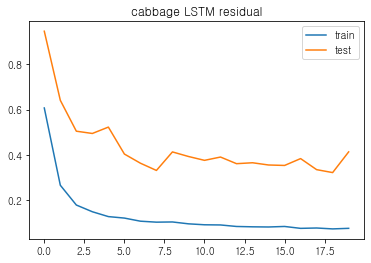

In [10]:
y_pred = model_LSTM(argi)

(1389, 90, 23) (1389, 1)
(1389, 90, 23) (1389, 1)
(1389, 90, 23) (1389, 1)
(1389, 90, 23) (1389, 1)


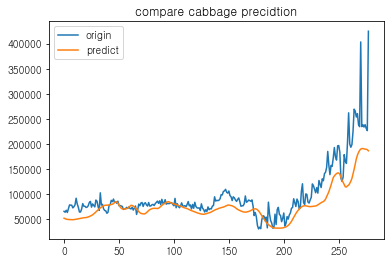

ValueError: y_true and y_pred have different number of output (1!=30)

In [11]:
comapare_plot(y_test,y_pred)

In [ ]:
y_pred.shape

#### 04-2. 양파 가격

In [ ]:
argi='onion'
data = load_data(argi,final_list)
data.head()

In [ ]:
train = make_dataset(data,90,1)[0]
target = make_dataset(data,90,1)[1]

In [ ]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

In [ ]:
y_pred = model_LSTM(argi)

In [ ]:
comapare_plot(y_test,y_pred)

#### 04-3. 새송이 가격

In [ ]:
argi='oyster'
data = load_data(argi,final_list)
data.head()

In [ ]:
train = make_dataset(data,90,1)[0]
target = make_dataset(data,90,1)[1]

In [ ]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

In [ ]:
y_pred = model_LSTM(argi)

In [ ]:
comapare_plot(y_test,y_pred)

#### 04-4. 건고추 가격

In [ ]:
argi='redpepper'
data = load_data(argi,final_list)
data.head()

In [ ]:
train = make_dataset(data,90,1)[0]
target = make_dataset(data,90,1)[1]

In [ ]:
#train test 분리
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, shuffle=False, random_state=120)
print('x_train.shape:',x_train.shape, 'x_train.shape:',y_train.shape)
print('x_test.shape:', x_test.shape, 'y_test.shape:',y_test.shape)

In [ ]:
y_pred = model_LSTM(argi)

In [ ]:
comapare_plot(y_test,y_pred)